In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Normal
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from dotted_dict import DottedDict
from utils import *
from datasets import *
from models import *

In [3]:
class VAEMnist():
    def __init__(self, d_in, d_hidden, d_z, device):
        self.d_in = d_in
        self.d_z = d_z
        self.d_hidden = d_hidden
        self.device = device
        #
        self.encoder = EncoderNormal(d_in, d_hidden, d_z)
        self.decoder = Decoder(d_z, d_hidden, d_in)
        #
        self.encoder.apply(init_weights)
        self.decoder.apply(init_weights)
        #
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
        
    
    def loss_rec(self, x_ori, x_rec):
        # Alternative MSE
        #loss = F.mse_loss(x_ori, x_rec)

        # Binary Cross Entropy
        # loss = F.binary_cross_entropy(x_rec, x_ori, reduction='sum')
        loss = x_ori * torch.log(1e-10 + x_rec) + (1 - x_ori) * torch.log(1 - x_rec)
        loss = - torch.sum(loss, axis=1)
        return loss
    
    def loss_kld(self, mu, logvar):
        loss = 1 + logvar - mu ** 2 - logvar.exp()
        loss = -0.5 * torch.sum(loss, dim = 1)
        return loss
    
    def loss_kld_approx(self, mu, logvar, z):
        #
        # P(z)
        p_prior = Normal(torch.zeros(self.d_z), torch.ones(self.d_z))
        
        # Q(z|x)
        std = torch.exp(0.5 * logvar)
        p_posterior = Normal(mu, std)
        
        loss_p = - p_prior.log_prob(z.cpu()).mean()
        loss_q = p_posterior.log_prob(z).mean()
        
        loss = loss_p + loss_q
        return loss
    
    def to(self, device):
        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
    
    def reparametrize(self, mu, logvar):
        #
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(logvar)
        #
        return eps * std + mu

    def train(self):
        self.encoder.train()
        self.decoder.train()
    
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()
    
    def compute_losses(self, x):
        x = x.to(config.device)
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        x_rec = self.decoder(z)
        p_prior = Normal(torch.zeros(self.d_z), torch.ones(self.d_z))
        
        # LOSS
        #----------------------------------------
        loss_rec = self.loss_rec(x, x_rec).mean()
        loss_kld = self.loss_kld(mu, logvar).mean()
        loss_aprox = self.loss_kld_approx(mu, logvar, z)
       
        return loss_rec, loss_kld, loss_aprox

    def encode(self, x):
        x = x.to(config.device)
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        return z
    
    def decode(self, z):
        return self.decoder(z)
    
    def P_sample(self, n):
        pass
    
    def P_pdf(self, x):
        pass
    
    def Q_sample(self, n):
        pass
    
    def Q_pdf(self, x):
        pass

In [4]:
config = {
    "num_epochs": 10,
    "batch_size": 512,
    "lr": 1e-3,
    "d_in": 28**2,
    "d_z": 2,
    "d_hidden": 1024,
    "device": "cuda:1",
    "freqs": {
        "print": 10,
        "plot_rec": 500,
        "plot_lat": 500,
        "plot_samp": 500,
        "plot_scatter": 500,
    },
    "loss": {
        'alpha': 1,
        'beta': 1,
        'gamma': 0,
    }
}
config = DottedDict(config)

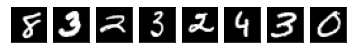

In [5]:
# DATA
transform = T.Compose([T.ToTensor(),
                       #T.Normalize((0.1307,), (0.3081,)),
                       T.Lambda(lambda x: torch.flatten(x))])
dl_train, dl_valid = get_dl_mnist(config.batch_size, transform, transform)


#### RECONSTRUCTION SAMPLE IMGS
n_vis = 8
x_vis, _ = next(iter(dl_valid))
x_vis = x_vis[:n_vis, :]
x_vis_ori = torch.reshape(x_vis, (n_vis, 28, 28)).numpy()
#
plot_batch(x_vis_ori)

In [6]:
# MODEL
vae = VAEMnist(config.d_in, config.d_hidden, config.d_z, config.device)

# OPTIMIZER
optimizer = torch.optim.Adam(list(vae.encoder.parameters()) + list(vae.decoder.parameters()), lr=config.lr)

Epoch [   0/  10] step     0: Loss: 546.7854, REC: 546.6180 KLD: 0.1674, APRX: 0.0681


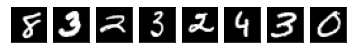

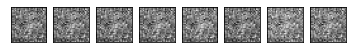

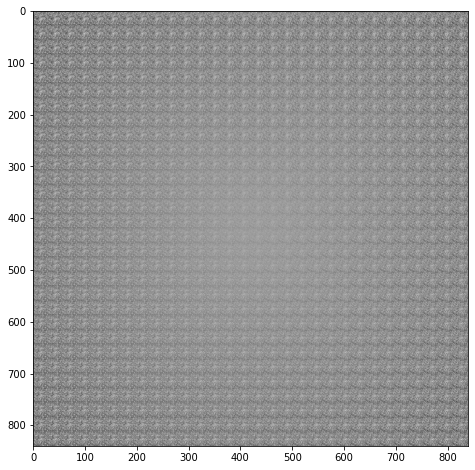

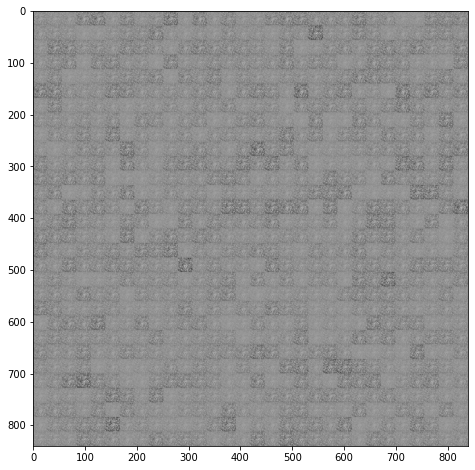

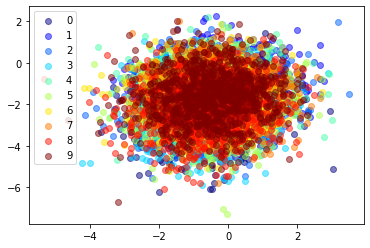

Epoch [   0/  10] step    10: Loss: 242.3057, REC: 227.5494 KLD: 14.7562, APRX: 7.4699
Epoch [   0/  10] step    20: Loss: 213.3041, REC: 209.2060 KLD: 4.0981, APRX: 2.0282
Epoch [   0/  10] step    30: Loss: 199.8658, REC: 197.7695 KLD: 2.0963, APRX: 1.0015
Epoch [   0/  10] step    40: Loss: 199.4458, REC: 197.2696 KLD: 2.1763, APRX: 1.1321
Epoch [   0/  10] step    50: Loss: 196.4580, REC: 194.2556 KLD: 2.2024, APRX: 1.1013
Epoch [   0/  10] step    60: Loss: 191.5818, REC: 189.3018 KLD: 2.2799, APRX: 1.1444
Epoch [   0/  10] step    70: Loss: 191.6014, REC: 188.7919 KLD: 2.8096, APRX: 1.3767
Epoch [   0/  10] step    80: Loss: 180.1356, REC: 176.6133 KLD: 3.5224, APRX: 1.7396
Epoch [   0/  10] step    90: Loss: 183.0601, REC: 179.4415 KLD: 3.6186, APRX: 1.8313
Epoch [   0/  10] step   100: Loss: 177.5499, REC: 173.6909 KLD: 3.8591, APRX: 1.8672
Epoch [   0/  10] step   110: Loss: 175.8070, REC: 171.8152 KLD: 3.9918, APRX: 1.9742
Epoch [   1/  10] step   120: Loss: 177.1216, REC: 17

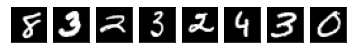

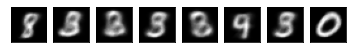

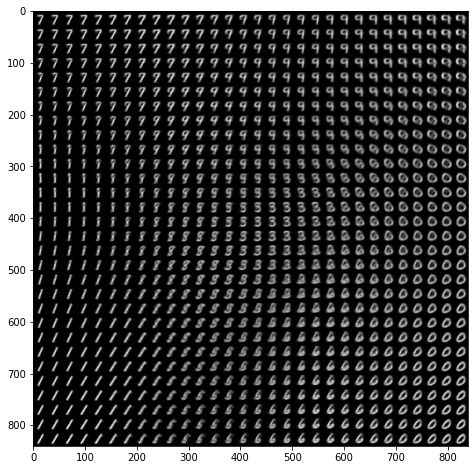

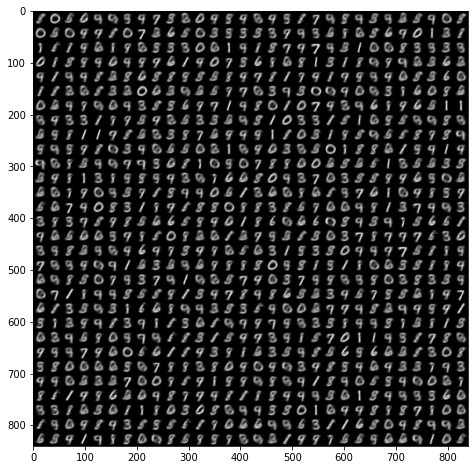

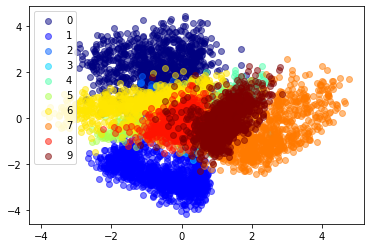

Epoch [   4/  10] step   510: Loss: 158.8126, REC: 153.4301 KLD: 5.3825, APRX: 2.7091
Epoch [   4/  10] step   520: Loss: 153.9376, REC: 148.4675 KLD: 5.4702, APRX: 2.7216
Epoch [   4/  10] step   530: Loss: 157.8580, REC: 152.5438 KLD: 5.3141, APRX: 2.6359
Epoch [   4/  10] step   540: Loss: 156.8259, REC: 151.2172 KLD: 5.6087, APRX: 2.7996
Epoch [   4/  10] step   550: Loss: 151.8011, REC: 146.3310 KLD: 5.4701, APRX: 2.7489
Epoch [   4/  10] step   560: Loss: 160.1638, REC: 154.6971 KLD: 5.4667, APRX: 2.7030
Epoch [   4/  10] step   570: Loss: 153.4497, REC: 147.8781 KLD: 5.5716, APRX: 2.7754
Epoch [   4/  10] step   580: Loss: 156.4721, REC: 151.1360 KLD: 5.3361, APRX: 2.6978
Epoch [   5/  10] step   590: Loss: 153.1109, REC: 147.4442 KLD: 5.6667, APRX: 2.8416
Epoch [   5/  10] step   600: Loss: 155.4935, REC: 150.0262 KLD: 5.4674, APRX: 2.7505
Epoch [   5/  10] step   610: Loss: 157.6799, REC: 152.1399 KLD: 5.5400, APRX: 2.7869
Epoch [   5/  10] step   620: Loss: 156.4116, REC: 150

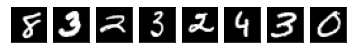

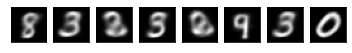

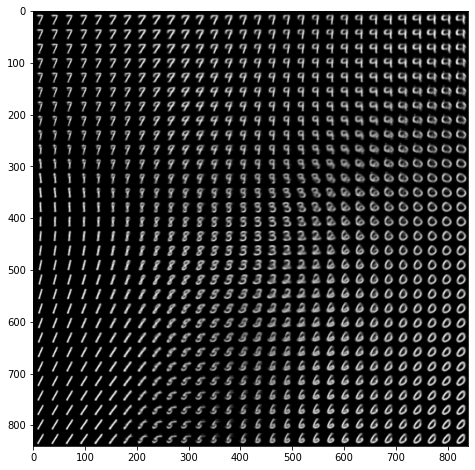

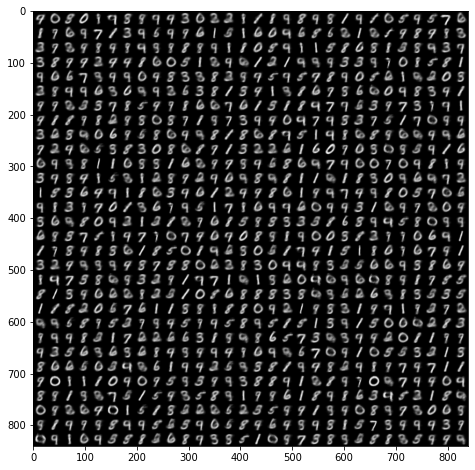

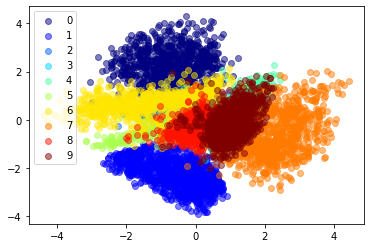

Epoch [   8/  10] step  1010: Loss: 152.3909, REC: 146.5393 KLD: 5.8516, APRX: 2.9158
Epoch [   8/  10] step  1020: Loss: 149.0984, REC: 143.3290 KLD: 5.7693, APRX: 2.8746
Epoch [   8/  10] step  1030: Loss: 152.2828, REC: 146.3870 KLD: 5.8957, APRX: 2.9366
Epoch [   8/  10] step  1040: Loss: 146.9897, REC: 141.1483 KLD: 5.8414, APRX: 2.9413
Epoch [   8/  10] step  1050: Loss: 149.7935, REC: 143.8342 KLD: 5.9593, APRX: 2.9849
Epoch [   8/  10] step  1060: Loss: 151.4427, REC: 145.5938 KLD: 5.8490, APRX: 2.9282
Epoch [   9/  10] step  1070: Loss: 149.9652, REC: 144.0423 KLD: 5.9229, APRX: 2.9228
Epoch [   9/  10] step  1080: Loss: 152.1733, REC: 146.1975 KLD: 5.9758, APRX: 2.9754
Epoch [   9/  10] step  1090: Loss: 151.2374, REC: 145.3932 KLD: 5.8442, APRX: 2.8972
Epoch [   9/  10] step  1100: Loss: 151.7760, REC: 145.9879 KLD: 5.7880, APRX: 2.9060
Epoch [   9/  10] step  1110: Loss: 150.3120, REC: 144.3795 KLD: 5.9325, APRX: 2.9569
Epoch [   9/  10] step  1120: Loss: 151.4868, REC: 145

In [7]:
s_loss = []
s_loss_kld = []
s_loss_rec = []
s_loss_apx = []
#
alpha = 1
beta = 1
gamma = 0
#
step = 0
#
for epoch_idx in range(config.num_epochs):
    vae.train()
    for x, _ in dl_train:
        x = x.to(config.device)
        
        #
        # FORWARD PASS & LOSSES
        #
        loss_rec, loss_kld, loss_aprox = vae.compute_losses(x)
        loss = alpha * loss_rec + beta * loss_kld + gamma * loss_aprox
        #
        s_loss.append(loss.item())
        s_loss_kld.append(loss_kld.item())
        s_loss_apx.append(loss_aprox.item())
        s_loss_rec.append(loss_rec.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #
        # TRACKING PROGRESS & VISUALIZATIONS
        #
        if step % config.freqs.print == 0:
            print_str = "Epoch [{:4}/{:4}] step {:5}: Loss: {:.4f}, REC: {:.4f} KLD: {:.4f}, APRX: {:.4f}"
            print_str = print_str.format(epoch_idx, config.num_epochs, step, loss.item(),
                                        loss_rec.item(), loss_kld.item(),
                                        loss_aprox.item())
            print(print_str)
        if step % config.freqs.plot_rec == 0:
            vae.eval()
            with torch.no_grad():
                x_vis_rec = vae.decode(vae.encode(x_vis))
                x_vis_rec = x_vis_rec.cpu().numpy().reshape((-1, 28, 28))
            plot_batch(x_vis_ori)
            plot_batch(x_vis_rec)
        
        if step % config.freqs.plot_lat == 0 and config.d_z == 2:
            vae.eval()
            img = get_latent_img(vae.decode, random_samples=False, device=config.device)
            fig, axs = plt.subplots(1, 1, figsize=(8, 8))
            axs.imshow(img, cmap="gray")
            plt.show()
        if step % config.freqs.plot_samp == 0:
            vae.eval()
            img = get_latent_img(vae.decode, d_z=config.d_z, random_samples=True, device=config.device)
            fig, axs = plt.subplots(1, 1, figsize=(8, 8))
            axs.imshow(img, cmap="gray")
            plt.show()
        if step % config.freqs.plot_scatter == 0 and config.d_z == 2:
            vae.eval()
            Z = []
            Y = []
            with torch.no_grad():
                for x, y in dl_valid:
                    z = vae.encode(x)
                    Z.append(z.cpu().numpy())
                    Y.append(y.numpy())
            Z = np.concatenate(Z)
            Y = np.concatenate(Y)
            scatter_with_legend(Z, Y)
        step += 1

In [ ]:
Z = []
Y = []
with torch.no_grad():
    for x, y in dl_valid:
        z = vae.encode(x)
        Z.append(z.cpu().numpy())
        Y.append(y.numpy())
    Z = np.concatenate(Z)
    Y = np.concatenate(Y)
scatter_with_legend(Z, Y)

In [ ]:
xx = range(len(s_loss))
#
fig, axes = plt.subplots(4, 1, figsize=(10, 10))
axes[0].plot(xx, s_loss)
axes[0].set_title("Total Loss")

axes[1].plot(xx, s_loss_rec)
axes[1].set_title("REC Loss")

axes[2].plot(xx, s_loss_kld)
axes[2].set_title("KLD Loss")

axes[3].plot(xx, s_loss_apx)
axes[3].set_title("NLL Loss")

plt.suptitle("Only Gamma")
plt.tight_layout()

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)

ax.set_yscale('log')

ax.plot(xx, s_loss_kld, label="kld")
ax.plot(xx, s_loss_apx, label="nll")
plt.legend()